In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import gmaps
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.ticker import FuncFormatter
import datetime
import requests
import json
from scipy import stats
from scipy.stats import linregress

In [2]:
world_df= pd.read_csv("../Resources/owid-covid-data.csv")


updated_world_df=world_df.drop(["iso_code", "new_deaths_per_million","total_tests","new_tests",
                                "new_tests_smoothed_per_thousand","population","median_age","aged_70_older",
                                "extreme_poverty","female_smokers","male_smokers",
                               "handwashing_facilities","hospital_beds_per_thousand","life_expectancy",
                               "new_tests_smoothed","new_tests_per_thousand","tests_units","total_deaths",
                               "new_deaths","total_cases_per_million","new_cases_per_million"], axis=1)

updated_world_df=updated_world_df.rename(columns={"location":"Country", "continent":"Continent","date":"Date",
                                                  "total_deaths_per_million":"Total Deaths Per Million","total_cases":"Total Cases", "new_cases":"New Cases",
                                                  "total_tests_per_thousand":"Total Test Per Thousands","diabetes_prevalence":"Diabetes Prevalence",
                                                 "population_density":"Population Density","aged_65_older":"Aged 65 or older",
                                                 "gdp_per_capita":"GDP Per Capita","cvd_death_rate":"Covid Death Rate",
                                                 "stringency_index":"Stringency Index"})

#updated_world_df.fillna(0, inplace=True)
updated_world_df=updated_world_df[updated_world_df["Date"]!= "2020-06-22" ]

updated_world_df.head()

,Continent,Country,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,Diabetes Prevalence
0,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,NaN,NaN,54.422,2.581,1803.987,597.029,9.59
1,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59
2,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59
3,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59
4,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59


In [3]:
#Number Hospital Beds is based on the lastest year per Country

data = pd.read_csv("../Resources/data.csv")

who_df = data.iloc[data.groupby("Country")["Year"].agg(pd.Series.idxmax)]
who_df.reset_index(drop=True).set_index("Country")
who_df=who_df.rename(columns={"Hospital beds (per 10 000 population)":"Hospital Beds (per 10K people)"})
hospital_beds_df=who_df.drop(["Year"], axis=1)

hospital_beds_df.head()

,Country,Hospital Beds (per 10K people)
0,Afghanistan,5
16,Albania,29
29,Algeria,19
31,Angola,8
32,Antigua and Barbuda,38


In [4]:
#Smoking Percentage is based on the lastest year per Country

smokingdata = pd.read_csv("../Resources/smokingdata.csv")

smokingdata_df = smokingdata.iloc[smokingdata.groupby("Country")["Year"].agg(pd.Series.idxmax)]

clean_smoking_data = smokingdata_df.drop(["Estimate of current cigarette smoking prevalence (%).1", "Estimate of current cigarette smoking prevalence (%).2", 
                                       "Estimate of current tobacco smoking prevalence (%)", "Estimate of current tobacco smoking prevalence (%).1", 
                                       "Estimate of current tobacco smoking prevalence (%).2", "Estimate of current tobacco use prevalence (%)", 
                                       "Estimate of current tobacco use prevalence (%).1", "Estimate of current tobacco use prevalence (%).2"], axis=1)

 
clean_smoking_data=clean_smoking_data.rename(columns={"Estimate of current cigarette smoking prevalence (%)":"Smoking Prevalence (%)"})
smoking_data = clean_smoking_data
smoking_prevalence=list(smoking_data["Smoking Prevalence (%)"])
smoking_percentage=[]

for x in smoking_prevalence:
    y=x.split("[")
    smoking_percentage.append(y[0])
    

    
column_values = pd.Series(smoking_percentage)
smoking_data.insert(loc=2, column="Smoking Percetage", value=column_values)
smoking_year_df=smoking_data.drop(["Smoking Prevalence (%)"], axis=1)

smoking_df=smoking_year_df.drop(["Year"], axis=1)

smoking_df.head()

,Country,Smoking Percetage
1,Albania,11.20
7,Algeria,15.20
13,Andorra,21.40
19,Argentina,31.40
25,Armenia,6.00


In [5]:
world_df=pd.read_csv("../Resources/dsh_simple.csv")

world_df=world_df[["Countryname","IfclosedduetoCOVID19whend","Statusof Schoolsaresomeall (copy) (group)",
          "Latitude (generated)","Longitude (generated)","Incomelevelname"]]

income_level_df=world_df.rename(columns={"Countryname":"Country", "Latitude (generated)":"Latitude", 
                      "Longitude (generated)": "Longitude", "Incomelevelname": "Income Level",
                        "Statusof Schoolsaresomeall (copy) (group)":"School Status"})
income_df=income_level_df.drop(["IfclosedduetoCOVID19whend"], axis =1)

income_df.head()

,Country,School Status,Latitude,Longitude,Income Level
0,Eritrea,Closed,15.9820,38.0200,Low income
1,Guinea-Bissau,Closed,12.1910,-14.4750,Low income
2,San Marino,Closed,43.9420,12.4611,High income
3,Georgia,Closed,42.0500,43.5760,Upper middle income
4,Italy,Closed,44.3713,11.1084,High income


In [6]:
combined_df=pd.merge(updated_world_df,hospital_beds_df,on="Country",how="left").merge(smoking_df,on="Country",how="left" ).merge(income_df,on="Country",how="left")

combined_df.head()

,Continent,Country,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,Diabetes Prevalence,Hospital Beds (per 10K people),Smoking Percetage,School Status,Latitude,Longitude,Income Level
0,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,NaN,NaN,54.422,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income
1,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income
2,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income
3,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income
4,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income


In [7]:
# delete the data for "2020-06-22" because it is not complete
combined_df=combined_df[combined_df['Date']!="2020-06-22"]

In [8]:
# get the daily case data for the world
world_data = combined_df[combined_df['Country']=='World']
world_cases=world_data['Total Cases'].values.tolist()

# get the daily case data for Africa
africa_cases = combined_df[(combined_df['Continent']=='Africa')].groupby("Date")
africa_cases_daily = africa_cases.sum()
africa_cases_list= africa_cases_daily['Total Cases'].values.tolist()

# get the daily case data for Asia
asia_cases = combined_df[(combined_df['Continent']=='Asia')].groupby("Date")
asia_cases_daily = asia_cases.sum()
asia_cases_list= asia_cases_daily['Total Cases'].values.tolist()

# get the daily case data for Europe
europe_cases = combined_df[(combined_df['Continent']=='Europe')].groupby("Date")
europe_cases_daily = europe_cases.sum()
europe_cases_list= europe_cases_daily['Total Cases'].values.tolist()

# get the daily case data for North America
north_america_cases = combined_df[(combined_df['Continent']=='North America')].groupby("Date")
north_america_cases_daily = north_america_cases.sum()
north_america_cases_list= north_america_cases_daily['Total Cases'].values.tolist()

# get the daily case data for Oceania
oceania_cases = combined_df[(combined_df['Continent']=='Oceania')].groupby("Date")
oceania_cases_daily = oceania_cases.sum()
oceania_cases_list= oceania_cases_daily['Total Cases'].values.tolist()

# get the daily case data for South America
south_america_cases = combined_df[(combined_df['Continent']=='South America')].groupby("Date")
south_america_cases_daily = south_america_cases.sum()
south_america_cases_list= south_america_cases_daily['Total Cases'].values.tolist()

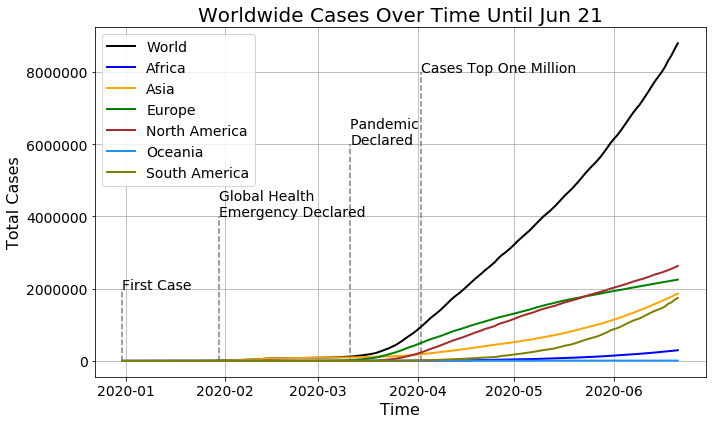

In [9]:
# change the dates to time series
dates = world_data['Date'].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

# plot of cases over time 
plt.figure(figsize=(10,6))

world_handle, = plt.plot(dates_values, world_cases,color="black",label="World",linewidth=2)
africa_handle, = plt.plot(dates_values, africa_cases_list,color="blue",label="Africa",linewidth=2)
asia_handle, = plt.plot(dates_values, asia_cases_list,color="orange",label="Asia",linewidth=2)
europe_handle, = plt.plot(dates_values, europe_cases_list,color="green",label="Europe",linewidth=2)
north_america_handle, = plt.plot(dates_values, north_america_cases_list,color="brown",label="North America",linewidth=2)
oceania_handle, = plt.plot(dates_values, oceania_cases_list,color="dodgerblue",label="Oceania",linewidth=2)
south_america_handle, = plt.plot(dates_values, south_america_cases_list,color="olive",label="South America",linewidth=2)

plt.legend(loc="upper left", fontsize=14)
plt.title("Worldwide Cases Over Time Until Jun 21", fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Time",fontsize=16)
plt.ylabel("Total Cases", fontsize=16)

# mark important dates in the plot
dates_important=["2019-12-31", "2020-01-30", "2020-03-11", "2020-04-02"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 2000000, colors='grey', linestyles='dashed', label='line1') #who declares covid a pandemic 
plt.vlines(dates_important_values[1], 0, 4000000, colors='grey', linestyles='dashed', label='line1') #first US case confirmed
plt.vlines(dates_important_values[2], 0, 6000000, colors='grey', linestyles='dashed', label='line1')
plt.vlines(dates_important_values[3], 0, 8000000, colors='grey', linestyles='dashed', label='line1')

plt.text(dates_important_values[0], 2000000,"First Case", size=14)
plt.text(dates_important_values[1], 4000000,"Global Health \nEmergency Declared", size=14)
plt.text(dates_important_values[2], 6000000,"Pandemic \nDeclared", size=14)
plt.text(dates_important_values[3], 8000000,"Cases Top One Million", size=14)

plt.tight_layout()
plt.grid()
plt.savefig('Worldwide Cases1.png', dpi=400)
plt.show()


In [10]:
# cases in different countries on Jun 21, 2020
countries_data = combined_df[(combined_df['Date']=='2020-06-21') & (combined_df['Country']!='World')]
# store country names into a list
countries_list = countries_data['Country'].values.tolist()

countries_data.head()

,Continent,Country,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,Diabetes Prevalence,Hospital Beds (per 10K people),Smoking Percetage,School Status,Latitude,Longitude,Income Level
163,Asia,Afghanistan,2020-06-21,28424.0,546.0,14.617,NaN,NaN,54.422,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.0230,65.5267,Low income
268,Europe,Albania,2020-06-21,1891.0,53.0,14.942,NaN,NaN,104.871,13.188,11803.431,304.195,10.08,29.0,11.20,Open with limitations,40.6540,20.0760,Upper middle income
437,Africa,Algeria,2020-06-21,11631.0,127.0,19.087,NaN,NaN,17.348,6.211,13913.839,278.364,6.73,19.0,15.20,Closed,28.6045,2.6400,Upper middle income
537,Europe,Andorra,2020-06-21,855.0,0.0,673.008,NaN,NaN,163.755,NaN,NaN,109.135,7.97,NaN,21.40,NaN,NaN,NaN,NaN
629,Africa,Angola,2020-06-21,172.0,6.0,0.243,NaN,NaN,23.890,2.405,5819.495,276.045,3.94,8.0,NaN,Closed,-12.8360,17.8080,Lower middle income


In [11]:
countries_data=countries_data.set_index('Country')
countries_data.head()

,Continent,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,Diabetes Prevalence,Hospital Beds (per 10K people),Smoking Percetage,School Status,Latitude,Longitude,Income Level
Country,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,2020-06-21,28424.0,546.0,14.617,NaN,NaN,54.422,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.0230,65.5267,Low income
Albania,Europe,2020-06-21,1891.0,53.0,14.942,NaN,NaN,104.871,13.188,11803.431,304.195,10.08,29.0,11.20,Open with limitations,40.6540,20.0760,Upper middle income
Algeria,Africa,2020-06-21,11631.0,127.0,19.087,NaN,NaN,17.348,6.211,13913.839,278.364,6.73,19.0,15.20,Closed,28.6045,2.6400,Upper middle income
Andorra,Europe,2020-06-21,855.0,0.0,673.008,NaN,NaN,163.755,NaN,NaN,109.135,7.97,NaN,21.40,NaN,NaN,NaN,NaN
Angola,Africa,2020-06-21,172.0,6.0,0.243,NaN,NaN,23.890,2.405,5819.495,276.045,3.94,8.0,NaN,Closed,-12.8360,17.8080,Lower middle income


# Use google API to find the lattitude and longitude for different countires, then save them into lists
# currently markdown, change to code when you want to check the heatmap
from config import gkey
lat_list=[]
lng_list=[]
country_update=[]
country_case_list=[]

for country in countries_list:
    
    params = {"address": country, "key": gkey}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params=params)
    country_geo = response.json()
    country_case = countries_data.loc[country, "Total Cases"]

    try:
        lat = country_geo["results"][0]["geometry"]["location"]["lat"]
        lng = country_geo["results"][0]["geometry"]["location"]["lng"]
        
        lat_list.append(lat)
        lng_list.append(lng)
        country_update.append(country)
        country_case_list.append(country_case)
        
        
    except:
        print("Country not found")
        pass

# google heatmap for cases on Jun 21
# currently markdown, change to code when you want to check the heatmap
gmaps.configure(api_key=gkey)
cases_map_df = pd.DataFrame({'Country':country_update,'Lat':lat_list, 'Lng':lng_list,"Case Number":country_case_list})
locations = cases_map_df[["Lat", "Lng"]].astype(float)
cases = cases_map_df['Case Number'].astype(float)

fig = gmaps.Map()

heat_layer = gmaps.heatmap_layer(locations, weights=cases, 
                                 dissipating=False, max_intensity=300000,
                                 point_radius =6)

fig.add_layer(heat_layer)

fig

In [12]:
# countries data with number index
countries_data_number_index=countries_data.reset_index()
countries_data_number_index.head()

,Country,Continent,Date,Total Cases,New Cases,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,Diabetes Prevalence,Hospital Beds (per 10K people),Smoking Percetage,School Status,Latitude,Longitude,Income Level
0,Afghanistan,Asia,2020-06-21,28424.0,546.0,14.617,NaN,NaN,54.422,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.0230,65.5267,Low income
1,Albania,Europe,2020-06-21,1891.0,53.0,14.942,NaN,NaN,104.871,13.188,11803.431,304.195,10.08,29.0,11.20,Open with limitations,40.6540,20.0760,Upper middle income
2,Algeria,Africa,2020-06-21,11631.0,127.0,19.087,NaN,NaN,17.348,6.211,13913.839,278.364,6.73,19.0,15.20,Closed,28.6045,2.6400,Upper middle income
3,Andorra,Europe,2020-06-21,855.0,0.0,673.008,NaN,NaN,163.755,NaN,NaN,109.135,7.97,NaN,21.40,NaN,NaN,NaN,NaN
4,Angola,Africa,2020-06-21,172.0,6.0,0.243,NaN,NaN,23.890,2.405,5819.495,276.045,3.94,8.0,NaN,Closed,-12.8360,17.8080,Lower middle income


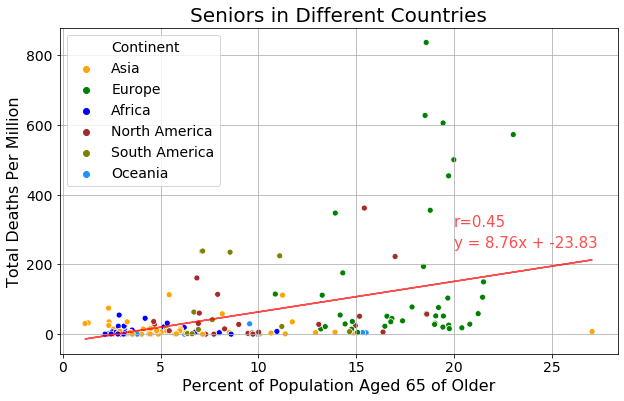

In [13]:
# scatter plot of people aged 65 or older vs. death per million worldwide
plt.figure(figsize=(10,6))

# linear regression and correlation
age_death=countries_data_number_index[["Aged 65 or older","Total Deaths Per Million",'Continent']]
age_death_updated=age_death.dropna()
x_values=age_death_updated["Aged 65 or older"]
y_values=age_death_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))

color_dict = dict({'Asia':'Orange',
                  'Europe':'green',
                  'Africa': 'blue',
                  'North America': 'brown',
                   'South America': 'olive',
                  'Oceania':'dodgerblue'})
sns.scatterplot(x="Aged 65 or older",y="Total Deaths Per Million", 
              hue="Continent",palette=color_dict, 
              data=age_death_updated)
plt.plot(x_values,regress_values,"r-",alpha=0.7)

plt.title("Seniors in Different Countries",fontsize=20)

plt.annotate(line_eq,(20,250),fontsize=15,color="red",alpha=0.7)
plt.annotate(correlation_eq,(20,310),fontsize=15,color="red",alpha=0.7)

plt.legend(loc="upper left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Percent of Population Aged 65 of Older",fontsize=16)
plt.ylabel("Total Deaths Per Million", fontsize=16)
plt.grid()
plt.savefig('Seniors in Different Countries.png', dpi=400)
plt.show()

In [14]:
# derive data for different continents
africa_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="Africa"]
asia_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="Asia"]
europe_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="Europe"]
north_america_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="North America"]
oceania_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="Oceania"]
south_america_65_cases_df=countries_data_number_index[countries_data_number_index['Continent']=="South America"]

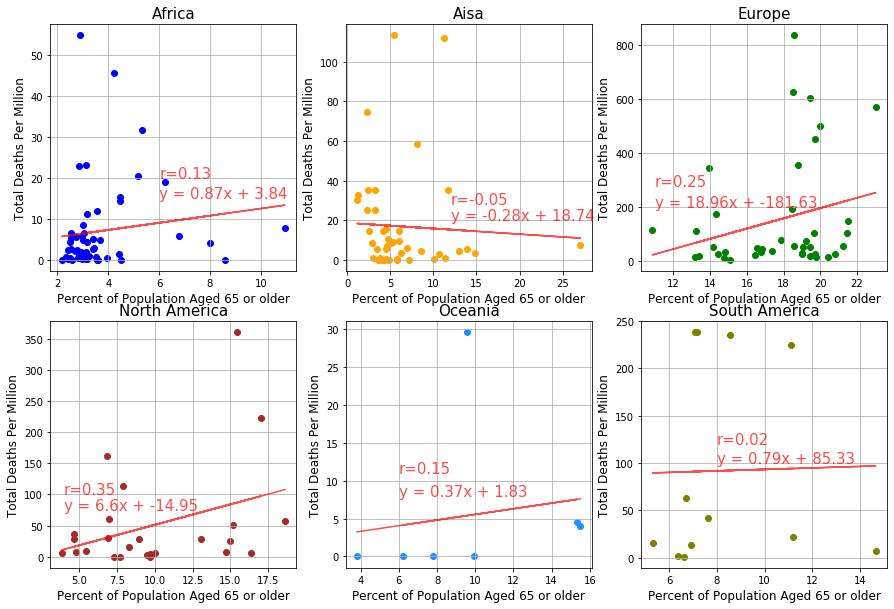

In [15]:
# scatter plot of people aged 65 or older vs. death per million break down by continents

fig, axs = plt.subplots(2,3,figsize=(15,10))

# africa
africa_65_cases_df_updated=africa_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
africa_65_cases_df_updated=africa_65_cases_df_updated.dropna()
x_values=africa_65_cases_df_updated["Aged 65 or older"]
y_values=africa_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[0,0].scatter(x_values, y_values,color='blue')
axs[0,0].plot(x_values,regress_values,"r-",alpha=0.7)
axs[0,0].set_title('Africa', size=15) # Title
axs[0,0].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12) 
axs[0,0].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[0,0].annotate(line_eq,(6,15),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[0,0].annotate(correlation_eq,(6,20),fontsize=15,color="red",alpha=0.7)
axs[0,0].grid()

# asia
aisa_65_cases_df_updated=asia_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
aisa_65_cases_df_updated=aisa_65_cases_df_updated.dropna()
x_values=aisa_65_cases_df_updated["Aged 65 or older"]
y_values=aisa_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[0,1].scatter(x_values, y_values,color='orange')
axs[0,1].plot(x_values,regress_values,"r-",alpha=0.7)
axs[0,1].set_title('Aisa', size=15) # Title
axs[0,1].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12)
axs[0,1].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[0,1].annotate(line_eq,(12,20),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[0,1].annotate(correlation_eq,(12,28),fontsize=15,color="red",alpha=0.7)
axs[0,1].grid()

# europe
europe_65_cases_df_updated=europe_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
europe_65_cases_df_updated=europe_65_cases_df_updated.dropna()
x_values=europe_65_cases_df_updated["Aged 65 or older"]
y_values=europe_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[0,2].scatter(x_values, y_values,color='green')
axs[0,2].plot(x_values,regress_values,"r-",alpha=0.7)
axs[0,2].set_title('Europe', size=15) # Title
axs[0,2].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12)
axs[0,2].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[0,2].annotate(line_eq,(11,200),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[0,2].annotate(correlation_eq,(11,280),fontsize=15,color="red",alpha=0.7)
axs[0,2].grid()

# North America
north_america_65_cases_df_updated=north_america_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
north_america_65_cases_df_updated=north_america_65_cases_df_updated.dropna()
x_values=north_america_65_cases_df_updated["Aged 65 or older"]
y_values=north_america_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[1,0].scatter(x_values, y_values,color='brown')
axs[1,0].plot(x_values,regress_values,"r-",alpha=0.7)
axs[1,0].set_title('North America', size=15) # Title
axs[1,0].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12) 
axs[1,0].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[1,0].annotate(line_eq,(4,75),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[1,0].annotate(correlation_eq,(4,100),fontsize=15,color="red",alpha=0.7)
axs[1,0].grid()


#oceania
oceania_65_cases_df_updated=oceania_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
oceania_65_cases_df_updated=oceania_65_cases_df_updated.dropna()
x_values=oceania_65_cases_df_updated["Aged 65 or older"]
y_values=oceania_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[1,1].scatter(x_values, y_values,color='dodgerblue')
axs[1,1].plot(x_values,regress_values,"r-",alpha=0.7)
axs[1,1].set_title('Oceania', size=15) # Title
axs[1,1].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12) 
axs[1,1].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[1,1].annotate(line_eq,(6,8),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[1,1].annotate(correlation_eq,(6,11),fontsize=15,color="red",alpha=0.7)
axs[1,1].grid()

#south america
south_america_65_cases_df_updated=south_america_65_cases_df[["Aged 65 or older","Total Deaths Per Million"]]
south_america_65_cases_df_updated=south_america_65_cases_df_updated.dropna()
x_values=south_america_65_cases_df_updated["Aged 65 or older"]
y_values=south_america_65_cases_df_updated["Total Deaths Per Million"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
axs[1,2].scatter(x_values, y_values,color='olive')
axs[1,2].plot(x_values,regress_values,"r-",alpha=0.7)
axs[1,2].set_title('South America', size=15) # Title
axs[1,2].set_xlabel('Percent of Population Aged 65 or older', fontsize = 12)
axs[1,2].set_ylabel('Total Deaths Per Million', fontsize = 12) 
axs[1,2].annotate(line_eq,(8,100),fontsize=15,color="red",alpha=0.7)
correlation = st.pearsonr(x_values,y_values)
correlation_eq="r="+str(round(correlation[0],2))
axs[1,2].annotate(correlation_eq,(8,120),fontsize=15,color="red",alpha=0.7)
axs[1,2].grid()

# plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('Death rate of the elder in different continents.png', dpi=400)
plt.show()